       SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
count     150.000000    150.000000     150.000000    150.000000
mean        5.843333      3.054000       3.758667      1.198667
std         0.828066      0.433594       1.764420      0.763161
min         4.300000      2.000000       1.000000      0.100000
25%         5.100000      2.800000       1.600000      0.300000
50%         5.800000      3.000000       4.350000      1.300000
75%         6.400000      3.300000       5.100000      1.800000
max         7.900000      4.400000       6.900000      2.500000


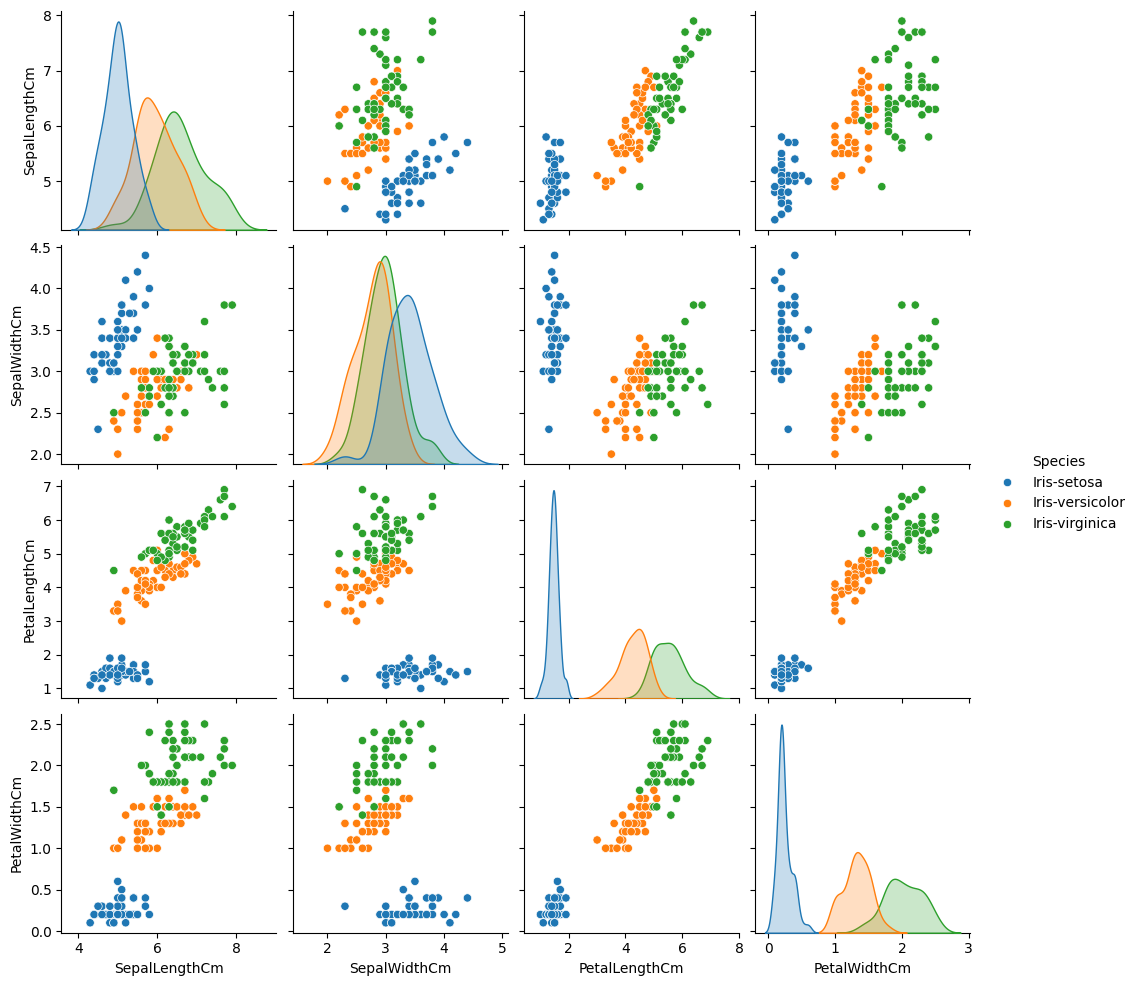

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Use custom PCA model
from pca_model import pca_transform, truncated_svd

# Use custom Logistic Regression model
from logr_model import logistic_regression_predict

# Read the data
df = pd.read_csv('data/iris.csv')

df = df.drop(columns='Id')
print(df.describe())

# Initial visualization before PCA with a pairplot
sns.pairplot(df, hue="Species")

Explained variance of the first 2 principal components: [0.72770452 0.23030523]


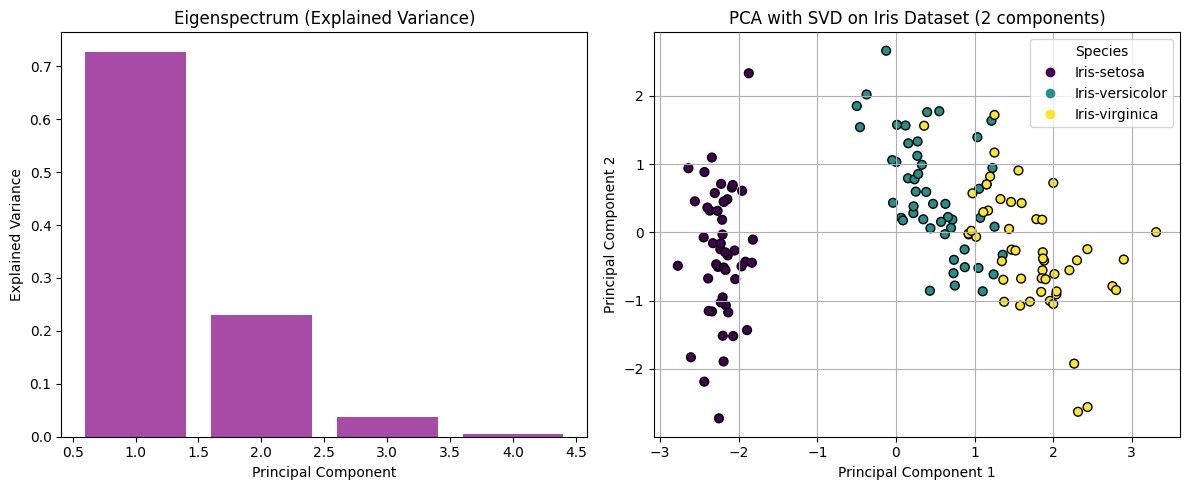

In [2]:
# Part 1: Reduce the data to 2 principal components and visualize with a 2D scatter plot

# Extract features and labels
X = df.drop(columns='Species').values
y = df['Species'].values

# Center and standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Perform PCA with SVD for 2 components
X_transformed = pca_transform(X, method='singular_value_decomposition', num_components=2)

U_k, Sigma_k, V_kt = truncated_svd(X, num_components=4)

# Calculate the explained variance for the available components
explained_variance = (Sigma_k**2) / np.sum(Sigma_k**2)
print(f"Explained variance of the first 2 principal components: {explained_variance[:2]}")

# Create the figure with subplots for the eigenspectrum and scatter plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, 5), explained_variance, color='purple', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Eigenspectrum (Explained Variance)')

plt.subplot(1, 2, 2)

species_to_num = {species: i for i, species in enumerate(df['Species'].unique())}
num_to_species = {i: species for species, i in species_to_num.items()}
species_encoded = np.array([species_to_num[species] for species in y])

scatter = plt.scatter(X_transformed[:, 0], X_transformed[:, 1], c=species_encoded, cmap='viridis', edgecolor='k', s=40)

plt.title('PCA with SVD on Iris Dataset (2 components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add legend with species names
handles, _ = scatter.legend_elements()
labels = [num_to_species[i] for i in range(len(df['Species'].unique()))]
plt.legend(handles, labels, title="Species")

plt.grid(True)

plt.tight_layout()
plt.show()

Explained variance of the first 2 principal components: [0.72770452 0.23030523]


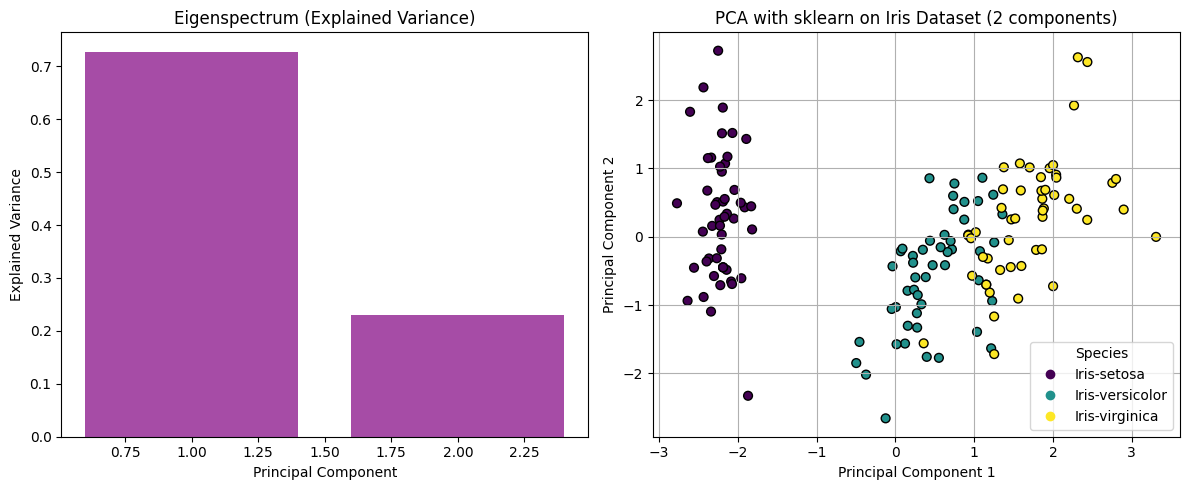

In [3]:
# Part 1: Using sklearn implementation for comparison
from sklearn.decomposition import PCA

# Perform PCA using sklearn for 2 components
pca = PCA(n_components=2)
X_transformed_sklearn = pca.fit_transform(X)

# Calculate the explained variance for the available components
explained_variance = pca.explained_variance_ratio_
print(f"Explained variance of the first 2 principal components: {explained_variance[:2]}")

# Create the figure with subplots for the eigenspectrum and scatter plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.bar(range(1, 3), explained_variance[:2], color='purple', alpha=0.7)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Eigenspectrum (Explained Variance)')

plt.subplot(1, 2, 2)

species_to_num = {species: i for i, species in enumerate(df['Species'].unique())}
num_to_species = {i: species for species, i in species_to_num.items()}
species_encoded = np.array([species_to_num[species] for species in y])

scatter = plt.scatter(X_transformed_sklearn[:, 0], X_transformed_sklearn[:, 1], c=species_encoded, cmap='viridis', edgecolor='k', s=40)

plt.title('PCA with sklearn on Iris Dataset (2 components)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Add legend with species names
handles, _ = scatter.legend_elements()
labels = [num_to_species[i] for i in range(len(df['Species'].unique()))]
plt.legend(handles, labels, title="Species")

plt.grid(True)

plt.tight_layout()
plt.show()

In [4]:
# Part 2: Compare performance of Logistic Regression on original and transformed data
# First apply Logistic Regression on the original data, capture metrics and confusion matrix
# Try 2 different approaches: split the data before transforming, then classify 
# and evaluate, or transform the data, then split, then classify and evaluate
# Data should be splitted to a 4:1 ratio, ensuring that the all splitted sets are 100% balanced

np.random.seed(42)

# Data preparation
X = df.drop(columns='Species').values
y = df['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}).values

X = scaler.fit_transform(X)

def stratified_split(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

# Approach: Split first, then transform (PCA after split)

# Split the original data
X_train, X_test, y_train, y_test = stratified_split(X, y, test_size=0.2)

# Apply PCA to training and test data
X_train_pca = pca_transform(X_train, method='singular_value_decomposition', num_components=2)
X_test_pca = pca_transform(X_test, method='singular_value_decomposition', num_components=2)

# Approach: Transform first, then split
X_pca_all = pca_transform(X, method='singular_value_decomposition', num_components=2)
X_train_pca_split, X_test_pca_split, y_train_pca_split, y_test_pca_split = stratified_split(X_pca_all, y, test_size=0.2)

# Logistic Regression on Original and Transformed Data
def evaluate_model(X_train, y_train, X_test, y_test, classification_type='softmax'):
    # Train and predict
    y_pred = logistic_regression_predict(X_train, y_train, X_test, max_iter=1000, learning_rate=0.05, type=classification_type)
    
    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)
    
    return accuracy, precision, recall, cm

# Evaluate Logistic Regression on original data
acc_orig, prec_orig, rec_orig, cm_orig = evaluate_model(X_train, y_train, X_test, y_test)

# Evaluate Logistic Regression on PCA-transformed data (Approach 1: Split first, then transform)
acc_pca_split_first, prec_pca_split_first, rec_pca_split_first, cm_pca_split_first = evaluate_model(X_train_pca, y_train, X_test_pca, y_test)

# Evaluate Logistic Regression on PCA-transformed data (Approach 2: Transform first, then split)
acc_pca_transformed_first, prec_pca_transformed_first, rec_pca_transformed_first, cm_pca_transformed_first = evaluate_model(X_train_pca_split, y_train_pca_split, X_test_pca_split, y_test_pca_split)

# Display the results
print("Logistic Regression on Original Data:")
print(f"Accuracy: {acc_orig:.4f}, Precision: {prec_orig:.4f}, Recall: {rec_orig:.4f}")
print(f"Confusion Matrix:\n{cm_orig}\n")

print("Logistic Regression on PCA (Split First, then Transform):")
print(f"Accuracy: {acc_pca_split_first:.4f}, Precision: {prec_pca_split_first:.4f}, Recall: {rec_pca_split_first:.4f}")
print(f"Confusion Matrix:\n{cm_pca_split_first}\n")

print("Logistic Regression on PCA (Transform First, then Split):")
print(f"Accuracy: {acc_pca_transformed_first:.4f}, Precision: {prec_pca_transformed_first:.4f}, Recall: {rec_pca_transformed_first:.4f}")
print(f"Confusion Matrix:\n{cm_pca_transformed_first}\n")

Logistic Regression on Original Data:
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000
Confusion Matrix:
[[10  0  0]
 [ 0 10  0]
 [ 0  0 10]]

Logistic Regression on PCA (Split First, then Transform):
Accuracy: 0.9000, Precision: 0.9024, Recall: 0.9000
Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  2  8]]

Logistic Regression on PCA (Transform First, then Split):
Accuracy: 0.9000, Precision: 0.9024, Recall: 0.9000
Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  2  8]]



In [5]:
# Part 2: Using sklearn implementation for reference
from sklearn.linear_model import LogisticRegression

# Data preparation
X = df.drop(columns='Species').values
y = df['Species'].map({'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}).values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

def stratified_split(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)

# Approach 1: Split first, then transform (PCA after split)
X_train, X_test, y_train, y_test = stratified_split(X_scaled, y)

# Apply PCA to training and test data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Approach 2: Transform first, then split
X_pca_all = pca.fit_transform(X_scaled)
X_train_pca_split, X_test_pca_split, y_train_pca_split, y_test_pca_split = stratified_split(X_pca_all, y)

# Logistic Regression on Original and Transformed Data
def evaluate_model(X_train, y_train, X_test, y_test):
    model = LogisticRegression(max_iter=1000, solver='lbfgs')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)

    return accuracy, precision, recall, cm

# Evaluate Logistic Regression on original data
acc_orig, prec_orig, rec_orig, cm_orig = evaluate_model(X_train, y_train, X_test, y_test)

# Evaluate Logistic Regression on PCA-transformed data (Approach 1)
acc_pca_split_first, prec_pca_split_first, rec_pca_split_first, cm_pca_split_first = evaluate_model(X_train_pca, y_train, X_test_pca, y_test)

# Evaluate Logistic Regression on PCA-transformed data (Approach 2)
acc_pca_transformed_first, prec_pca_transformed_first, rec_pca_transformed_first, cm_pca_transformed_first = evaluate_model(X_train_pca_split, y_train_pca_split, X_test_pca_split, y_test_pca_split)

# Display the results
print("Logistic Regression on Original Data:")
print(f"Accuracy: {acc_orig:.4f}, Precision: {prec_orig:.4f}, Recall: {rec_orig:.4f}")
print(f"Confusion Matrix:\n{cm_orig}\n")

print("Logistic Regression on PCA (Split First, then Transform):")
print(f"Accuracy: {acc_pca_split_first:.4f}, Precision: {prec_pca_split_first:.4f}, Recall: {rec_pca_split_first:.4f}")
print(f"Confusion Matrix:\n{cm_pca_split_first}\n")

print("Logistic Regression on PCA (Transform First, then Split):")
print(f"Accuracy: {acc_pca_transformed_first:.4f}, Precision: {prec_pca_transformed_first:.4f}, Recall: {rec_pca_transformed_first:.4f}")
print(f"Confusion Matrix:\n{cm_pca_transformed_first}\n")

Logistic Regression on Original Data:
Accuracy: 0.9333, Precision: 0.9333, Recall: 0.9333
Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  1  9]]

Logistic Regression on PCA (Split First, then Transform):
Accuracy: 0.9000, Precision: 0.9024, Recall: 0.9000
Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  2  8]]

Logistic Regression on PCA (Transform First, then Split):
Accuracy: 0.9000, Precision: 0.9024, Recall: 0.9000
Confusion Matrix:
[[10  0  0]
 [ 0  9  1]
 [ 0  2  8]]

